In [17]:
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe # for white outline around text
import matplotlib.colors as colors
from shapely.geometry import LineString
from shapely import wkt
import json
import folium
%matplotlib inline

Loading our data:

In [18]:
# Loading csv straight into geopandas seems to be funky
# So I'll load into pandas first and apply shapely wkt.loads function first
data = pd.read_csv("../data/gis_data.csv")
data_percent = pd.read_csv("../data/gis_data_percent.csv")
data_totals = pd.read_csv('../data/gis_data_totals.csv')

data['geometry'] = data['geometry'].apply(wkt.loads)
data_percent['geometry'] = data_percent['geometry'].apply(wkt.loads)
data_totals['geometry'] = data_totals['geometry'].apply(wkt.loads)

gdf = gpd.GeoDataFrame(data)
gdf_percent = gpd.GeoDataFrame(data_percent)
gdf_totals = gpd.GeoDataFrame(data_totals)

<Axes: >

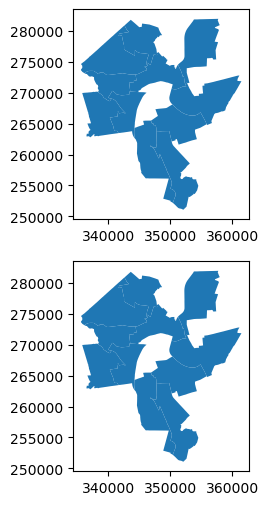

In [19]:
fig, axes = plt.subplots(2,1, figsize=(10,6))
gdf.plot(ax=axes[0])
gdf_percent.plot(ax=axes[1])

<Axes: >

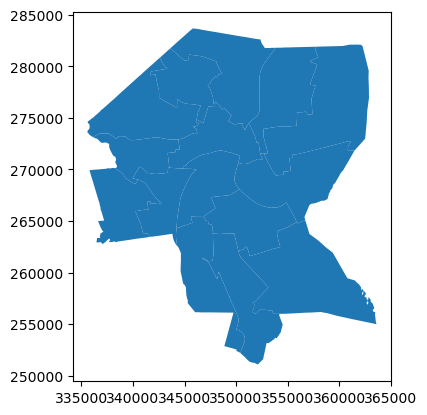

In [20]:
gdf_pvd = gpd.read_file("../data/BND_PVD_Wards_2022.shp")
gdf_pvd.plot()

In [21]:
np.unique(gdf['DISTRICT'])

array([ 1,  3,  5,  6,  7,  8,  9, 11, 12, 14, 15], dtype=int64)

We're missing information on Wards 2, 4, and 13 in our data, which reflects in the plot. Maybe we can add them back in but with NA values?

In [22]:
districts = [2,4,13]
for district in districts:
    gdf = pd.concat([gdf, gdf_pvd.iloc[[district-1]]])
    gdf_percent = pd.concat([gdf_percent, gdf_pvd.iloc[[district-1]]])
    gdf_totals = pd.concat([gdf_totals, gdf_pvd.iloc[[district-1]]])

c:\Users\DWang\anaconda3\envs\evc\Lib\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83(2011) / Rhode Island (ftUS) (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
c:\Users\DWang\anaconda3\envs\evc\Lib\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83(2011) / Rhode Island (ftUS) (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
c:\Users\DWang\anaconda3\envs\evc\Lib\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83(2011) / Rhode Island (ftUS) (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [23]:
gdf = gdf.set_index("ID").sort_index()
gdf_percent = gdf_percent.set_index("ID").sort_index()
gdf_totals = gdf_totals.set_index("ID").sort_index()

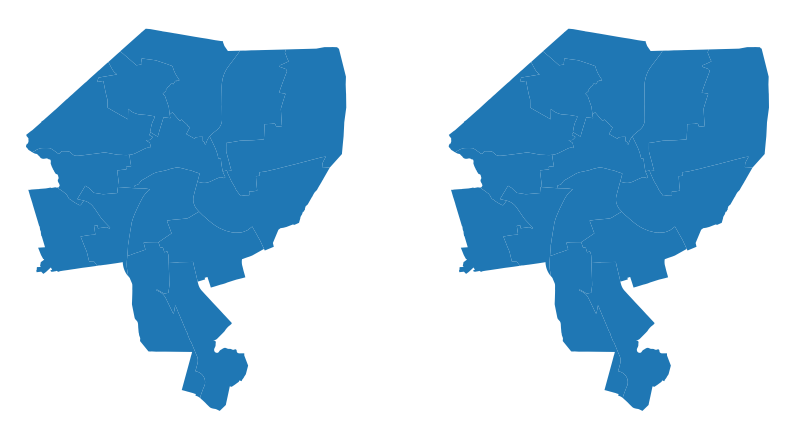

In [24]:
fig, axes = plt.subplots(1,2, figsize=(10,6))
gdf.plot(ax=axes[0])
gdf_percent.plot(ax=axes[1])
axes[0].set_axis_off()
axes[1].set_axis_off()

Playing around with the plotting options

Text(0.5, 1.0, 'Q19_Definitely Not')

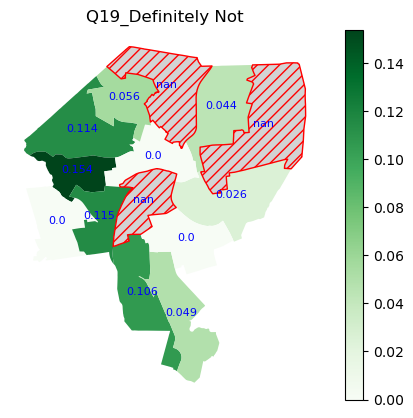

In [25]:
column_name = 'Q19_Definitely Not'
ax = gdf_percent.plot(
    column=column_name,
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values"
    }, cmap="Greens")
ax.set_axis_off()

for idx, row in gdf_percent.iterrows():
    plt.text(x=row.geometry.centroid.x,
             y=row.geometry.centroid.y, 
             s = str(round(row[column_name],3)), 
             fontsize=8,
             color="blue" ,
             ha='center')
plt.title(column_name)

Let's plot the total response counts and percentages per ward. This'll tell us if some wards are represented more than others.

Text(0.5, 1.0, 'Total Percentage of Responses by Ward')

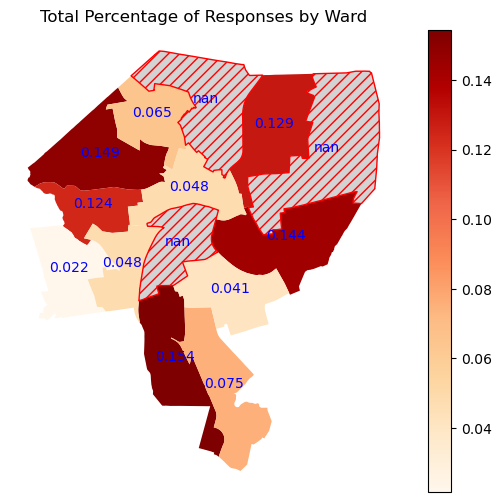

In [26]:
column_name = 'Percentage' #'Count'
df = gdf_totals 

ax = df.plot(
    column=column_name,
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values"
    }, 
    cmap="OrRd",
    figsize=(8,6))
ax.set_axis_off()

for idx, row in df.iterrows():
    _convert_int = lambda x: int(x) if pd.notna(x) else x
    #ward_string = str(_convert_int(row[column_name]))
    ward_string = str(round(row[column_name],3))
    plt.text(x=row.geometry.centroid.x,
            y=row.geometry.centroid.y, 
            s = ward_string, 
            fontsize=10,
            color="blue",
            ha='center')
plt.title(f"Total {column_name} of Responses by Ward")

Can we compare these percentages to the total voter turnout by ward? Let's compare it to the 2020 elections.

In [27]:
turnout_2020 = pd.read_csv("../data/turnout_2020.csv")
# set 0 values for the missing wards (for plotting and average % response calculations)
turnout_2020 = turnout_2020.set_index('Ward')
for ward_num in [2, 4, 13]:
    turnout_2020.loc[ward_num,'SUM of 2020 Turnout'] = 0
turnout_2020['PERCENT of 2020 Turnout'] = turnout_2020['SUM of 2020 Turnout'] / np.sum(turnout_2020['SUM of 2020 Turnout'])
turnout_2020_gdf = gdf_totals.merge(turnout_2020, left_on='DISTRICT', right_on='Ward', how='left')
turnout_2020_gdf

,DISTRICT,DISTRICTN,Shape_STAr,Shape_STLe,geometry,Count,Percentage,SUM of 2020 Turnout,PERCENT of 2020 Turnout
0,1,1.0,4.626871e+07,37132.487547,"POLYGON ((353880.285 269409.163, 354275.176 26...",80.0,0.143627,5859.0,0.130586
1,2,2.0,6.857744e+07,45920.952108,"POLYGON ((353740.517 269601.048, 353659.443 26...",NaN,NaN,NaN,NaN
2,3,3.0,3.952432e+07,33051.393756,"POLYGON ((352200.695 272587.857, 352185.706 27...",72.0,0.129264,4747.0,0.105802
3,4,4.0,4.590033e+07,37093.253292,"POLYGON ((350897.885 273804.377, 350888.071 27...",NaN,NaN,NaN,NaN
4,5,5.0,4.342423e+07,37105.452695,"POLYGON ((341271.842 272989.464, 341151.392 27...",83.0,0.149013,3821.0,0.085163
5,6,6.0,2.091428e+07,25538.226701,"POLYGON ((341072.364 272964.21, 341151.392 272...",69.0,0.123878,1463.0,0.032607
6,7,7.0,2.983633e+07,30271.723284,"POLYGON ((335779.467 269938.082, 335904.304 26...",12.0,0.021544,3493.0,0.077852
7,8,8.0,3.567477e+07,39440.578601,"POLYGON ((349492.58 256111.482, 349458.761 256...",86.0,0.154399,2293.0,0.051107
8,9,9.0,3.798385e+07,38994.863784,"POLYGON ((352102.808 251083.51, 352075.79 2510...",42.0,0.075404,2702.0,0.060222
9,11,11.0,3.199302e+07,27702.548389,"POLYGON ((351227.874 261975.2, 351115.2 262319...",23.0,0.041293,4414.0,0.098380


Text(0.5, 1.0, 'Total SUM of 2020 Turnout of Responses by Ward')

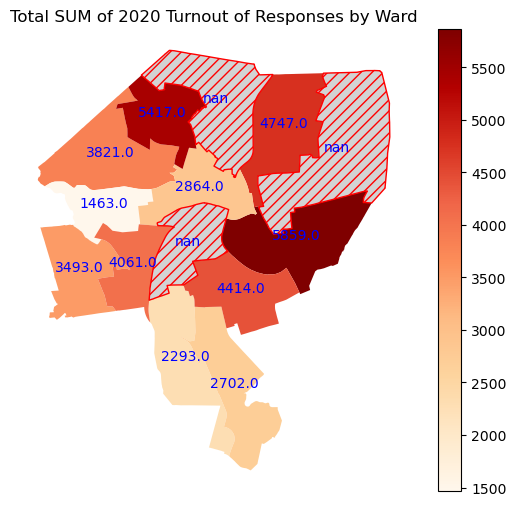

In [28]:
column_name =  'SUM of 2020 Turnout'
df = turnout_2020_gdf

ax = df.plot(
    column=column_name,
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values"
    }, 
    cmap="OrRd",
    figsize=(8,6))
ax.set_axis_off()

for idx, row in df.iterrows():
    _convert_int = lambda x: int(x) if pd.notna(x) else x
    #ward_string = str(_convert_int(row[column_name]))
    ward_string = str(round(row[column_name],3))
    plt.text(x=row.geometry.centroid.x,
            y=row.geometry.centroid.y, 
            s = ward_string, 
            fontsize=10,
            color="blue",
            ha='center')
plt.title(f"Total {column_name} of Responses by Ward")

Can we combine column values in the maps? E.g. if we wanted to showcase the number/proportion of people in each ward that voted "Probably" OR "Definitely"?

Can we parameterize the inputs so that it's easy to swap questions in and out? Could be useful for dashboarding.

In [29]:
with open("../data/question_mapping.json", "r") as f:
    question_mapping = json.load(f)

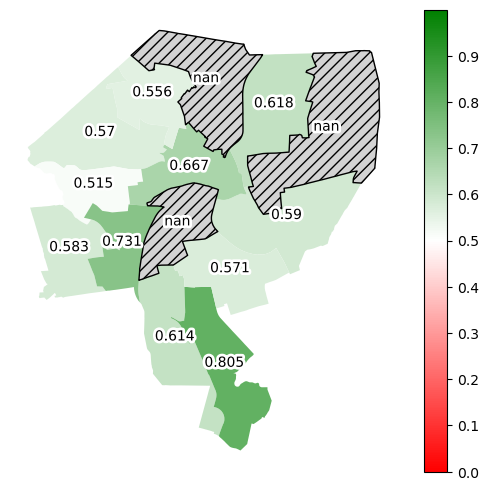

In [43]:
def print_plot(
        question_number: int,
        question_choices: list,
        percent_df: bool = False
) -> None:
    if percent_df: 
        df = gdf_percent
        measure = "Percent"
        vmin = 0
        vmax = 1
        legend_ticks = np.arange(vmin,vmax,0.1)
    else: 
        df = gdf
        measure = "Count"
        vmin = 0
        vmax = None
        legend_ticks = None

    plotting_df = gdf.iloc[:,0:5].copy()
    value_df = pd.DataFrame(0, columns = ['plot_value'], index=df.index)

    # Define a colormap that shows colors red --> green for values 0 --> 1

    red_to_green_cmap=colors.LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

    #red_to_green_cmap = colors.LinearSegmentedColormap('RedGreen', cdict)

    for choice in question_choices:
        column_name = f"Q{question_number}_{choice}"
        temp_df = np.array(df[column_name]).reshape(-1)
        value_df['plot_value'] += temp_df
    plotting_df['plot_value'] = value_df['plot_value']

    vmin = 0
    if percent_df: vmax = 1
    else: vmax = max(plotting_df['plot_value'] + 5)

    ax = plotting_df.plot(
        column="plot_value",
        legend=True,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "black",
            "hatch": "///",
            "label": "Missing values"
        }, 
        legend_kwds={
            "ticks": legend_ticks
        },
        cmap=red_to_green_cmap,
        vmin=vmin,
        vmax=vmax,
        figsize=(7,6))
    ax.set_axis_off()

    for idx, row in plotting_df.iterrows():
        _convert_int = lambda x: int(x) if pd.notna(x) else x
        if percent_df: ward_string = str(round(row["plot_value"],3))
        else: ward_string = str(_convert_int(row["plot_value"]))
        plt.text(x=row.geometry.centroid.x,
                y=row.geometry.centroid.y, 
                s = ward_string, 
                fontsize=10,
                color="black",
                path_effects=[pe.withStroke(linewidth=4, foreground="white")],
                ha='center')
    
    #plt.title(loc='left', label=f'{measure} of "Probably" and "Definitely" Responses to Q{question_number} by Ward')
    #plt.figtext(0.1, -0.01, f"Q{question_number}: \n{question_mapping[f'Q{question_number}']}", wrap = True)

print_plot(20, ['Probably', 'Definitely'], True)

Dashboarding TODO:

- Build in Dash (from Plotly)

- Deploy to Heroku or free alternative (alwaysdata.com?)

In [31]:
question_number = "Q4"
question_text = question_mapping[question_number]
popups = [column for column in gdf_percent.columns if question_number in column]
popups.insert(0, "Q1")

m = gdf_percent.explore(
    column=popups[0],  # make choropleth based on "POP2010" column
    cmap='Purples',
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  # show legend
    k=6,  # bins of values
    tooltip="DISTRICT",  # hide tooltip
    popup=popups,  # show popup (on-click)
    legend_kwds=dict(colorbar=False),  # do not use colorbar
    name=question_number  # name of the layer in the map
)
m

c:\Users\DWang\anaconda3\envs\evc\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
